In [1]:
import whitebox
import os
import matplotlib.pyplot as plt
import imageio
import geopandas as gp
from scipy import misc 
import glob as glob
import numpy as np
import shutil
import georasters as gr
%matplotlib inline

parent = os.path.dirname(os.path.abspath(os.getcwd()))
wd = parent + '/datasets/stamp_data'

from WBT.whitebox_tools import WhiteboxTools
wbt = WhiteboxTools()
wbt.set_verbose_mode(False)

/opt/anaconda3/envs/py3k/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/opt/anaconda3/envs/py3k/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# tile the las file

In [3]:

wbt.set_working_dir(wd)

if os.path.isdir(wd + '/stamp/'):
    shutil.rmtree(wd + '/stamp/') 

width = 100
height = 100
pts = 'stamp.las'
# breaks lidar into tiles; all tiles stored in folder with name of original las file
wbt.lidar_tile(
    i=pts, 
    width=width, 
    height=height, 
    origin_x=0.0, 
    origin_y=0.0, 
    min_points=2)

0

In [4]:
# get tile files list, create folders for point densities (total and ground)
fs = glob.glob(wd + '/stamp/*.las')
os.system('mkdir ' + wd + '/stamp/densities')
os.system('mkdir ' + wd + '/stamp/gd_densities')

# resolution of lpi raster, and radius over which points are counted
res = 2.0
radius_of_effect = 2.0

# easily parallelized, for loop for now
for f in fs:
    # navigate into tiles folder and calculate densities for current tile
    wbt.set_working_dir(wd + '/stamp')
    wbt.lidar_point_density(
            i=f, 
            output='density.tif',resolution=res,radius=radius_of_effect
        )
    wbt.lidar_point_density(
            i=f, 
            output='gd_density.tif', exclude_cls='1',resolution=res,radius=radius_of_effect
        )
    wbt.set_working_dir(wd)
    
    # create raster density for all points, project it using gdal
    tosave = f.split('/')[-1].split('.')[0] + '_density.tif'
    source = wd + '/stamp/density.tif'
    target = wd + '/stamp/densities/' + tosave
    cmd = 'gdalwarp -s_srs EPSG:26910 -t_srs EPSG:26910 ' + source + ' ' + target
    os.system(cmd)
    # load density as georasters
    rtotal = gr.from_file(target)
    
    # create raster density for ground
    tosave = f.split('/')[-1].split('.')[0] + '_gd_density.tif'
    source = wd + '/stamp/gd_density.tif'
    target = wd + '/stamp/gd_densities/' + tosave
    cmd = 'gdalwarp -s_srs EPSG:26910 -t_srs EPSG:26910 ' + source + ' ' + target
    os.system(cmd)
    # load ground point density
    rground = gr.from_file(target)
    
    
    # lpi is just ratio of ground to total
    lpi_current = rtotal**(-1)*rground
    
    # merge current lpi tile with total raster
    # if first tile, create the lpi raster
    if f==fs[0]:
        lpi = lpi_current.copy()
    lpi = lpi.union(lpi_current)

Text(9.0, 0.5, 'count')

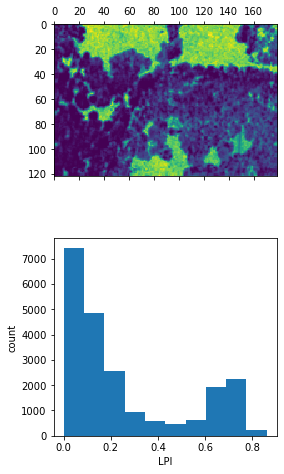

In [5]:
f,axs = plt.subplots(2,figsize=(4,8))
lpi.plot(ax=axs[0])
ax = axs[1]
ax.hist(lpi.raster.data.flatten())
ax.set_xlabel('LPI')
ax.set_ylabel('count')

In [ ]:

# dem = os.path.join(wd,'stamp_dem.tif')
# breached = os.path.join(wd, 'stamp_dem_breached.tif')
# d8 = os.path.join(wd, 'stamp_dem_d8.tif')
# dinf = os.path.join(wd, 'stamp_dem_dinf.tif')
# accum = os.path.join(wd, 'stamp_dem_accum.tif')
# basins = os.path.join(wd, 'stamp_dem_basins.tif')
# basins_poly = os.path.join(wd, 'stamp_dem_basins.shp')

# wbt.flow_accumulation_full_workflow(
#     dem, 
#     out_dem=breached, 
#     out_pntr=d8, 
#     out_accum=accum, 
#     out_type="catchment area", 
#     log=False, 
#     clip=False, 
#     esri_pntr=False
# )


# streams200 =  os.path.join(wd, 'stamp_dem_streams200.tif')

# wbt.extract_streams(
#     accum, 
#     output=streams200, 
#     threshold=200, 
#     zero_background=True)
